### Transfer Learning includes two types:
#### 1. Use pretrained weights as initialization
#### 2. Use pretrained weights as feature extractor, and only retrain the last several layers

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy



In [7]:
data_transforms = {
    "train":transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    "val":transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    
}

In [8]:
data_dir = "hymenoptera_data"
image_datasets = {x:datasets.ImageFolder(os.path.join(data_dir,x), data_transforms[x]) for x in ["train", "val"]}

In [32]:
dataloaders = {x:torch.utils.data.DataLoader(image_datasets[x], batch_size=4, shuffle=True, num_workers=4) for x in ["train", "val"]}

In [39]:
dataset_sizes = {x:len(image_datasets[x]) for x in ["train", "val"]}
class_names = image_datasets["train"].classes
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [11]:
device

device(type='cpu')

### visualize a few images

In [12]:
def imshow(inp, title= None):
    inp = inp.numpy().transpose((1,2,0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title:
        plt.title(title)
    plt.pause(0.001)
    

In [14]:
inputs, classes = next(iter(dataloads["train"]))

In [16]:
out = torchvision.utils.make_grid(inputs)

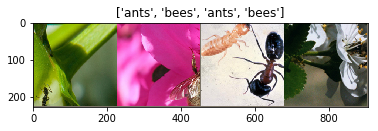

In [20]:
imshow(out, title = [class_names[x] for x in classes])

### Training the model

In [34]:
def train_model(model, criterion, optimizer, schedular, num_epochs = 25):
    since = time.time()
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    for epoch in range(num_epochs):
        print("Epoch {}/{}".format(epoch,num_epochs-1))
        print("-" * 10)
        
        for phase in ["train", "val"]:
            if phase == "train":
                ### .step() is used to update the learning rate/gradients ###
                schedular.step()
                model.train()
            else:
                model.eval()
                
            running_loss = 0.0
            running_corrects = 0.0
            
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                optimizer.zero_grad()
                
                with torch.set_grad_enabled(phase == "train"):
                    outputs = model(inputs)
                    ### return the max value in outputs with both value and indice ###
                    ### Here, 1 is the dimension to reduce ###
                    _,preds = torch.max(outputs,1)
                    ### loss are averaged across observations for each minibatch ###
                    loss = criterion(outputs,labels)
                    
                    if phase == "train":
                        loss.backward()
                        optimizer.step()
                
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                
            epoch_loss = running_loss / dataset_sizes[phase]
            ### tensor.double() is to convert the tensor type into torch.float64 ###
            epoch_acc = running_corrects.double()/dataset_sizes[phase]
            
            print('{} Loss: {:.4f} Acc:{:.4f}'.format(phase, epoch_loss, epoch_acc))
            
            if phase == "val" and epoch_acc > best_acc:
                best_acc  = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
    
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))
    
    model.load_state_dict(best_model_wts)
    
    return model                  
    

In [45]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()
    
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders["val"]):
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(inputs)
            _,preds = torch.max(outputs, 1)
            for j in range(inputs.size(0)):
                images_so_far +=1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])
                
                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode = was_training)

In [23]:
### If no pretrained=True, you can construct a model with trandom weights ###
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 2)
model_ft = model_ft.to(device)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /Users/jianinglu1/.torch/models/resnet18-5c106cde.pth
46827520it [00:00, 61853945.75it/s]


In [24]:
criterion = nn.CrossEntropyLoss()

In [26]:
optimizer_ft = optim.SGD(model_ft.parameters(), lr = 0.001, momentum = 0.9)

In [27]:
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [40]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler)

Epoch 0/24
----------
train Loss: 0.4143 Acc:0.8320
val Loss: 0.2023 Acc:0.9150
Epoch 1/24
----------
train Loss: 0.4527 Acc:0.8361
val Loss: 0.4526 Acc:0.8105
Epoch 2/24
----------
train Loss: 0.4279 Acc:0.8156
val Loss: 0.2350 Acc:0.9216
Epoch 3/24
----------
train Loss: 0.3485 Acc:0.8689
val Loss: 0.2251 Acc:0.9150
Epoch 4/24
----------
train Loss: 0.3336 Acc:0.8607
val Loss: 0.2067 Acc:0.9346
Epoch 5/24
----------
train Loss: 0.2944 Acc:0.8689
val Loss: 0.1864 Acc:0.9216
Epoch 6/24
----------
train Loss: 0.3985 Acc:0.8484
val Loss: 0.1950 Acc:0.9150
Epoch 7/24
----------
train Loss: 0.3534 Acc:0.8279
val Loss: 0.2282 Acc:0.9150
Epoch 8/24
----------
train Loss: 0.2749 Acc:0.8975
val Loss: 0.1896 Acc:0.9150
Epoch 9/24
----------
train Loss: 0.2376 Acc:0.9057
val Loss: 0.1790 Acc:0.9216
Epoch 10/24
----------
train Loss: 0.2639 Acc:0.8893
val Loss: 0.2233 Acc:0.9216
Epoch 11/24
----------
train Loss: 0.2393 Acc:0.9180
val Loss: 0.2013 Acc:0.9150
Epoch 12/24
----------
train Loss: 0.2

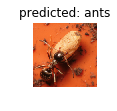

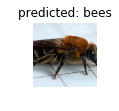

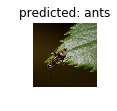

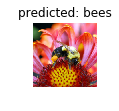

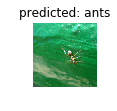

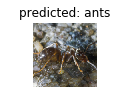

In [46]:
visualize_model(model_ft)

### ConvNet as fixed feature extractor

In [50]:
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    ### requires_grad=False indicates no gradient calculation for parameters ###
    param.requires_grad = False
### Parameters of newly constructed modules have requires_grad=True by default ##
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)


In [51]:
model_conv = model_conv.to(device)
criterion = nn.CrossEntropyLoss()

In [52]:
### Only optimize the fc paramters ###
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr = 0.001, momentum=0.9)

In [53]:
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [55]:
model_conv = train_model(model_conv, criterion, optimizer_conv, exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.6079 Acc:0.6721
val Loss: 0.2230 Acc:0.9150
Epoch 1/24
----------
train Loss: 0.5263 Acc:0.7336
val Loss: 0.2851 Acc:0.9020
Epoch 2/24
----------
train Loss: 0.4608 Acc:0.8402
val Loss: 0.5027 Acc:0.7843
Epoch 3/24
----------
train Loss: 0.5954 Acc:0.7418
val Loss: 0.1818 Acc:0.9477
Epoch 4/24
----------
train Loss: 0.4545 Acc:0.8115
val Loss: 0.1802 Acc:0.9412
Epoch 5/24
----------
train Loss: 0.3641 Acc:0.8402
val Loss: 0.3978 Acc:0.8562
Epoch 6/24
----------
train Loss: 0.4117 Acc:0.8074
val Loss: 0.2054 Acc:0.9412
Epoch 7/24
----------
train Loss: 0.3898 Acc:0.8238
val Loss: 0.1809 Acc:0.9412
Epoch 8/24
----------
train Loss: 0.3905 Acc:0.8279
val Loss: 0.1886 Acc:0.9412
Epoch 9/24
----------
train Loss: 0.4488 Acc:0.7828
val Loss: 0.1835 Acc:0.9477
Epoch 10/24
----------
train Loss: 0.3076 Acc:0.8689
val Loss: 0.2083 Acc:0.9281
Epoch 11/24
----------
train Loss: 0.2949 Acc:0.8689
val Loss: 0.1746 Acc:0.9477
Epoch 12/24
----------
train Loss: 0.4

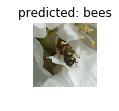

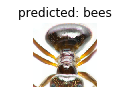

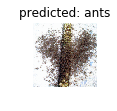

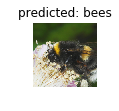

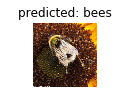

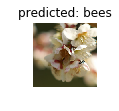

In [56]:
visualize_model(model_conv)


### Notes:

1. Load pretrained model, should use torchvision, and if pretrained=True, the model keeps the pretrained weights
2. Transfer Learning: should set requires_grads for non-retrained weights as False, and retrained weights as True, also, the optimizer should only optimize the retrained weights
3. Three major parts in model training: optimizer.zero_grad() --> loss.backward() --> optimizer.step()